In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from utils.preprocessing import create_time_matrix, create_caregivers_df, create_tasks_df, create_clients_df

caregivers = create_caregivers_df('data/raw/caregivers.csv')

tasks = create_tasks_df('data/raw/hemtjanst_tasks.csv', only_client_tasks=True)

clients = create_clients_df('data/raw/clients.csv')

drive_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_DRIVE.csv')
walk_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_WALK.csv')
bicycle_time_matrix = create_time_matrix('data/raw/matrix_duration_matrix_BICYCLE.csv')

In [2]:
# Test1: Subset with only caregivers 33, 949, 1108 and their tasks
test1_subset = [33, 949, 1108]
caregivers_test1 = caregivers.loc[test1_subset]
tasks_test1 = tasks[tasks['PlannedCaregiverID'].isin(test1_subset)]

print(f"Number of caregivers in subset: {len(caregivers_test1)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test1)}")

# Test2: Subset with only first 10 caregivers that use car as mode of transport
car_caregivers = caregivers[caregivers['ModeOfTransport'] == 'car']
caregivers_test2 = car_caregivers.head(10)
tasks_test2 = tasks[tasks['PlannedCaregiverID'].isin(caregivers_test2.index)]

print(f"Number of caregivers in subset: {len(caregivers_test2)}")
print(f"Number of tasks assigned to subset caregivers: {len(tasks_test2)}")

Number of caregivers in subset: 3
Number of tasks assigned to subset caregivers: 27
Number of caregivers in subset: 10
Number of tasks assigned to subset caregivers: 86


In [3]:
from models.flexible_model import FlexibleModel
model_caregivers = caregivers_test1
model_tasks = tasks_test1

flexible_model = FlexibleModel(model_caregivers, model_tasks, clients, drive_time_matrix, walk_time_matrix, bicycle_time_matrix)
flexible_model.build()
flexible_model.optimize()

Set parameter Username
Set parameter LicenseID to value 2634432
Academic license - for non-commercial use only - expires 2026-03-10
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 24.3.0 24D81)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2545 rows, 2355 columns and 13722 nonzeros
Model fingerprint: 0xfaeac050
Variable types: 87 continuous, 2268 integer (2268 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+02]
Presolve removed 2386 rows and 1673 columns
Presolve time: 0.04s
Presolved: 159 rows, 682 columns, 1958 nonzeros
Variable types: 6 continuous, 676 integer (676 binary)
Found heuristic solution: objective 1554.3833333

Root relaxation: objective 1.564101e+02, 372 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |   

<gurobi.Model MIP instance HomeCare: 2545 constrs, 2355 vars, Parameter changes: Username=(user-defined), LicenseID=2634432>

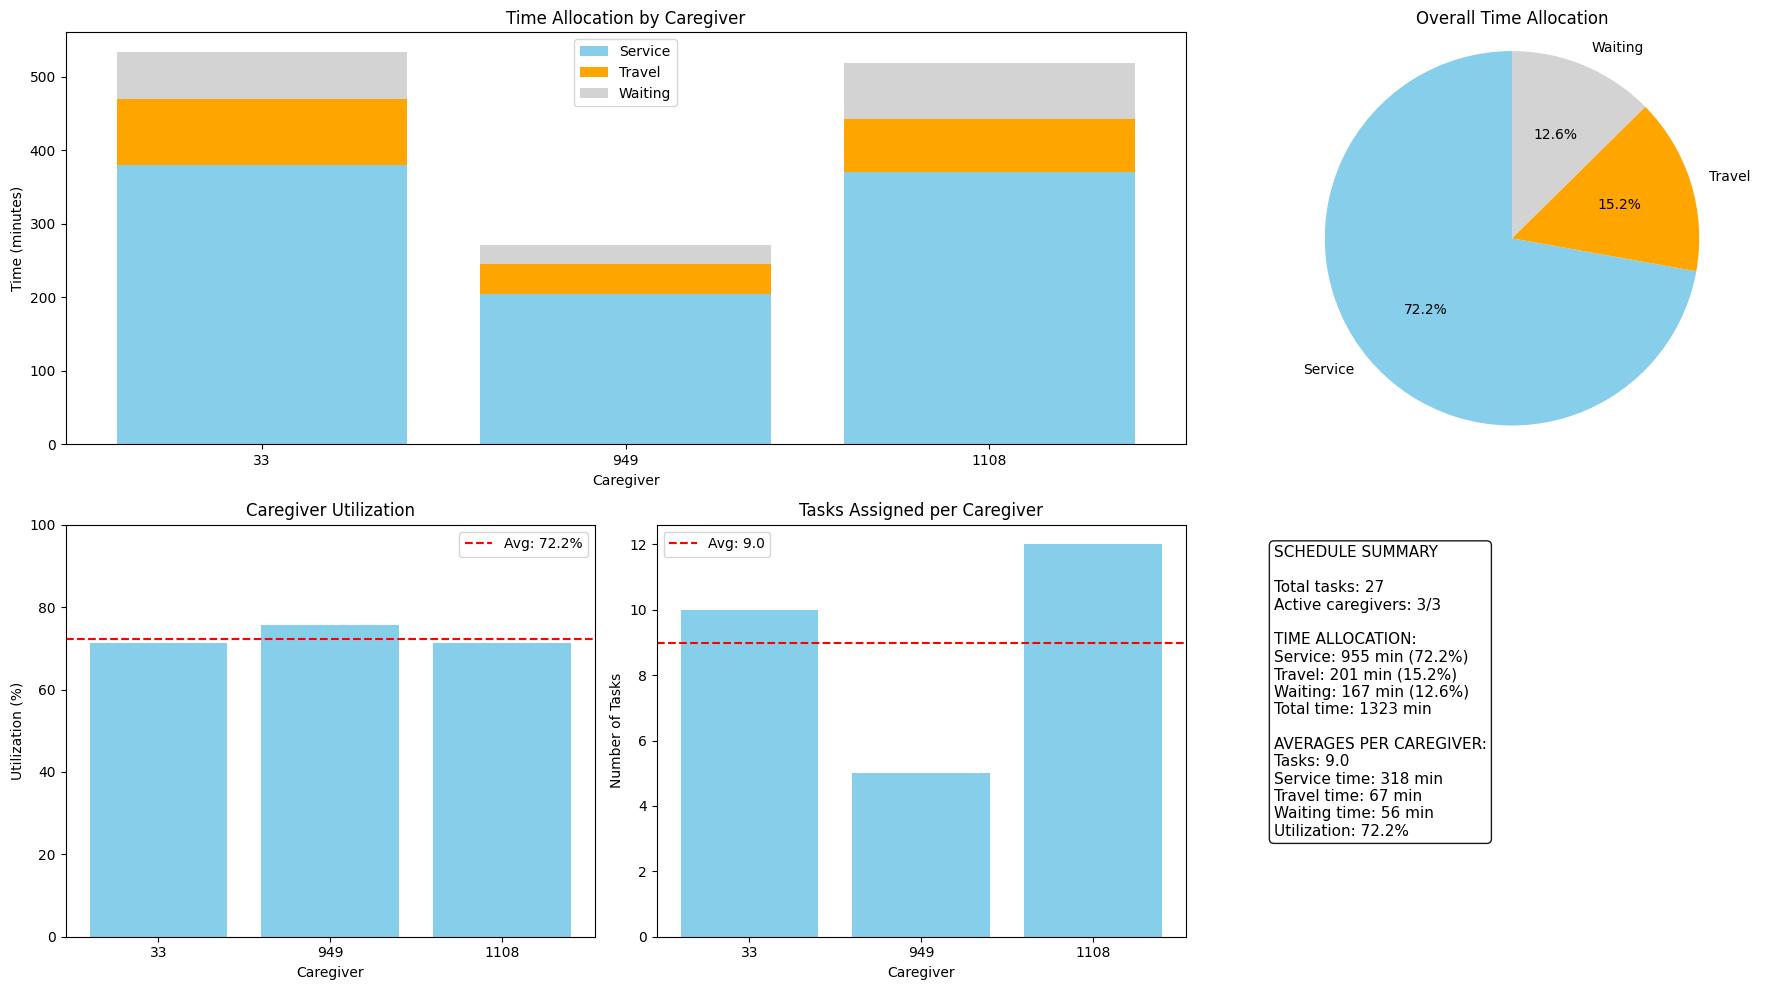

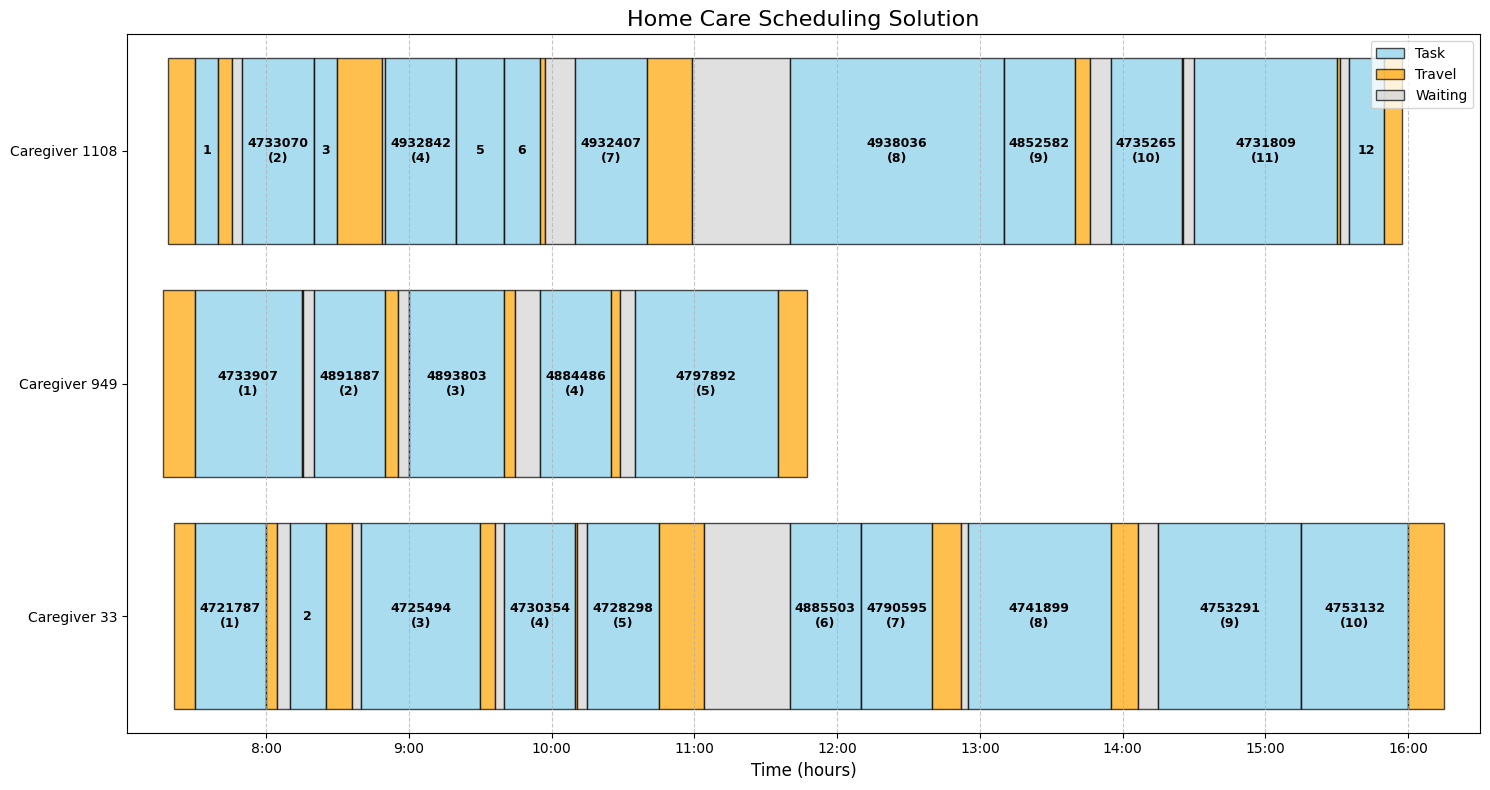

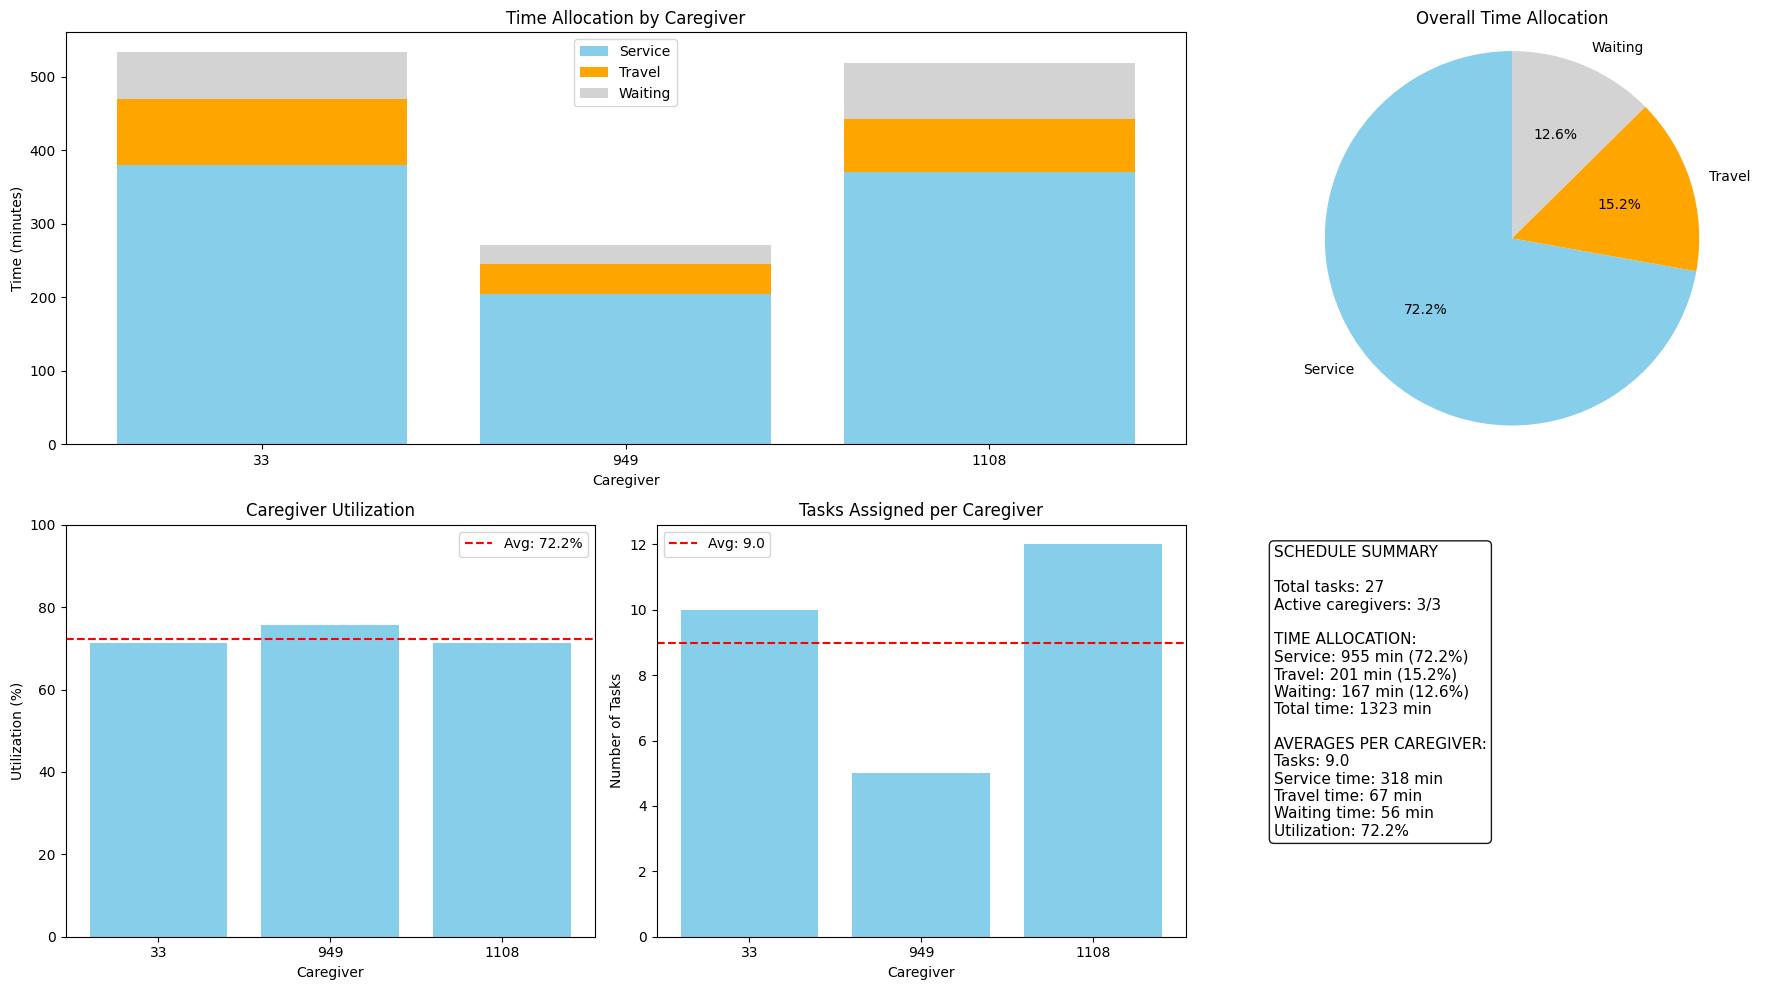

In [ ]:
from utils.visualization import visualize_schedule, visualize_metrics, create_summary_dashboard

flexible_model.get_solution()

visualize_schedule(flexible_model)
visualize_metrics(flexible_model)